In [16]:
import os
import sys
import h5py
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal as signal

In [6]:
# database full path
database_name = 'whistlers.h5'
database_location = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'Data')
database_path = os.path.join(database_location,database_name)

# data variables
awd_events = 2
sites = ['marion', 'sanae']



In [12]:
def vr2_to_panda(dir_name,fname, site):
    """Extract the data from a file a store it as a Panda DataFrame
    inputs
        fname    file name
        site     name of the site where data was collected
    outputs 
        whdf     dataframe containing the signal received by the NS and EW pointitng
                    orthogonal loop antennas
        fs       sampling frequency
        t0       start time
        t1       end time
    """
    # read vr2 file
    wh = frread(os.path.join(dir_name,fname))
    
    # CONSTANTS
    # Sampling frequency (20kHz for SANAE, 40kHz for MARION )
    fs = 2e4 if site=="sanae" else 4e4
    # time step in microseconds (for dataframe index)
    dt = 1e6 / fs

    # Set the date/time format in the filename
    # dtFormat = '%Y-%m-%dUT%H_%M_%S.%f'
    dtFormat = '%Y-%m-%dUT%H:%M:%S.%f'

    # Set up pandas dataframe
    # Start time
    t0 = pd.datetime.strptime(fname[0:27], dtFormat)
    # Number of samples
    Nsamples = len(wh[:, 0])
    # End time
    t1 = t0 + datetime.timedelta(0, 0, Nsamples * dt)
    # Create index
    tindex = pd.date_range(start=t0, periods=Nsamples, freq='50U') # freq = 50us

    # Create pandas data frame from wh
    whdf = pd.DataFrame(index=tindex, data=wh[:, 0], columns=['X'])
    whdf['Y'] = wh[:, 1]
    # The 'X' and 'Y' columns are the signal received by the North/South and
    # East/West pointing orthogonal loop antennas used at Marion and SANAE
    
    return whdf, fs
def frread(fname=None):
    """ This is a rough translation of frread.m from J. Lichtenberger for the
    stereo=True case, i.e. we assume orthogonal loop antenna.
    inputs
        fname (string): File name path to the .vr2 file to load
    outputs
        wh (ndarray): 2xN array with the two traces in the first and second rows.
    """
    # open file for reading
    fid = open(fname, 'rb')
    # get data from file - 16-bit signed integers
    dat = np.fromfile(fid, dtype=np.int16)
    # length of one frame
    frLen = 4103  ## not sure how this is determined
    # number of frames to read
    nFrameRead = len(dat) / frLen
    # data length of frame
    adatlen = 2048
    # length of data set
    N = int(nFrameRead * adatlen)
    wh = np.zeros((N, 2), dtype=float)
    # for every frame
    for i in np.arange(0, nFrameRead, dtype=int):
        # indices for first component
        i1 = np.arange(7 + i * frLen, (i + 1) * frLen, 2, dtype=int)
        # indices for second component
        i2 = np.arange(8 + i * frLen, (i + 1) * frLen + 0, 2, dtype=int)
        ii = np.arange(i * adatlen, (i + 1) * adatlen, dtype=int)
        wh[ii, 0] = dat[i1]
        wh[ii, 1] = dat[i2]
#     print(len(np.arange(0, nFrameRead, dtype=int)))
    return wh

(257, 959)
(257, 2239)


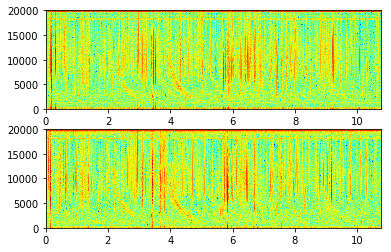

In [38]:
data_location = os.path.join(database_location, 'awdEvents'+str(1), sites[0], sites[0]+'_data')

_f  = h5py.File(database_path, 'r')
# load from labelled data
grp_spe = _f[os.path.join('awdEvents'+str(1), sites[0],'labelled spectrograms')]
files = list(grp_spe.keys())
# select a file of interest
file = files[np.random.randint(len(files))] # select a random sample
_f.close()

# get spectrogram 
data, fs =  vr2_to_panda(data_location, file, sites[0])


# spectrogram variable
detrend='linear'
NFFT=512
noverlap=64
scale='dB'
scale_by_freq=False
cmap='jet'

# using matplolib
plt.subplot(2,1,1)
s_m, f_m, t_m, img = plt.specgram(data.X.values, Fs=fs, detrend='linear', NFFT=512 , noverlap=64, 
                                    scale='dB', scale_by_freq=False, cmap='jet', mode='magnitude') 
# using scipy
f_s, t_s, s_s = signal.spectrogram(data.X.values, fs=fs, detrend='linear', nfft=512 , noverlap=64, 
                                   scaling='spectrum', mode='magnitude')
plt.subplot(2,1,2)
plt.pcolormesh(t_s, f_s, np.log10(s_s), cmap='jet')
print(s_m.shape)
print(s_s.shape)